In [1]:
import os
import re
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def get_concurrency_parallelism(cc_value):
    value = int(sqrt(cc_value))
    return value, value

def process_log_files(directory,string):
    dataframes = []
    for filename in os.listdir(directory):
        if filename.startswith(string) and filename.endswith(".log"):
            full_path = os.path.join(directory, filename)
            with open(full_path, 'r') as file:
                data = []
                last_non_zero_throughput = None
                for line in file:
                    match = re.search(r'(\d+\.\d+).*Throughput @(\d+\.\d+)s:\s+(\d+\.\d+)Gbps, lossRate: (\d+\.\d+|\d+) CC:(\d+)\s+score:(-?\d+\.\d+)\s+rtt:(\d+\.\d+) ms energy:(\d+\.\d+) Jules s-plr:(\d+\.\d+)', line)
                    if match:
                        time = datetime.fromtimestamp(float(match.group(1)))
                        throughput = float(match.group(3))
                        if throughput == 0.00 and last_non_zero_throughput is not None:
                            throughput = last_non_zero_throughput
                        elif throughput != 0.00:
                            last_non_zero_throughput = throughput

                        loss_rate = float(match.group(4))
                        cc = int(match.group(5))
                        score = float(match.group(6))
                        rtt = float(match.group(7))
                        energy = float(match.group(8))
                        sender_lr = float(match.group(9))
                        concurrency, parallelism = get_concurrency_parallelism(cc)
                        data.append([time, throughput, loss_rate, cc, score, rtt, energy, sender_lr, concurrency, parallelism])

                df = pd.DataFrame(data, columns=['Time', 'Throughput', 'receiver_lr', 'CC', 'Score', 'RTT', 'Energy', 'sender_lr', 'concurrency', 'parallelism'])
                # Fill in zero throughput with the previous non-zero value
#                 df['Throughput'] = df['Throughput'].replace(0, np.nan)
#                 df['Throughput'].fillna(method='ffill', inplace=True)
                dataframes.append(df)
    return dataframes



                         Time  Throughput  receiver_lr  CC  Score   RTT  \
0  2023-12-26 23:48:50.599430        0.00          0.0  64    0.0   0.0   
1  2023-12-26 23:48:51.593938        0.00          0.0  64    0.0   0.0   
2  2023-12-26 23:48:52.595299        0.00          0.0  64    0.0  32.6   
3  2023-12-26 23:48:53.596257        0.00          0.0  64    0.0  32.6   
4  2023-12-26 23:48:54.595800        0.00          0.0  64    0.0  32.6   
5  2023-12-26 23:48:55.598473        0.00          0.0  64    0.0  32.6   
6  2023-12-26 23:48:56.631736        0.00          0.0  64    0.0  32.5   
7  2023-12-26 23:48:57.634277        0.00          0.0  64    0.0  39.2   
8  2023-12-26 23:48:58.602869        0.00          0.0  64    0.0  33.3   
9  2023-12-26 23:48:59.630089       18.88          0.0  64    5.0  36.8   
10 2023-12-26 23:49:00.649868        0.64          0.0  64    0.0  33.0   
11 2023-12-26 23:49:01.619473       10.56          0.0  64 -278.0  33.4   
12 2023-12-26 23:49:02.64

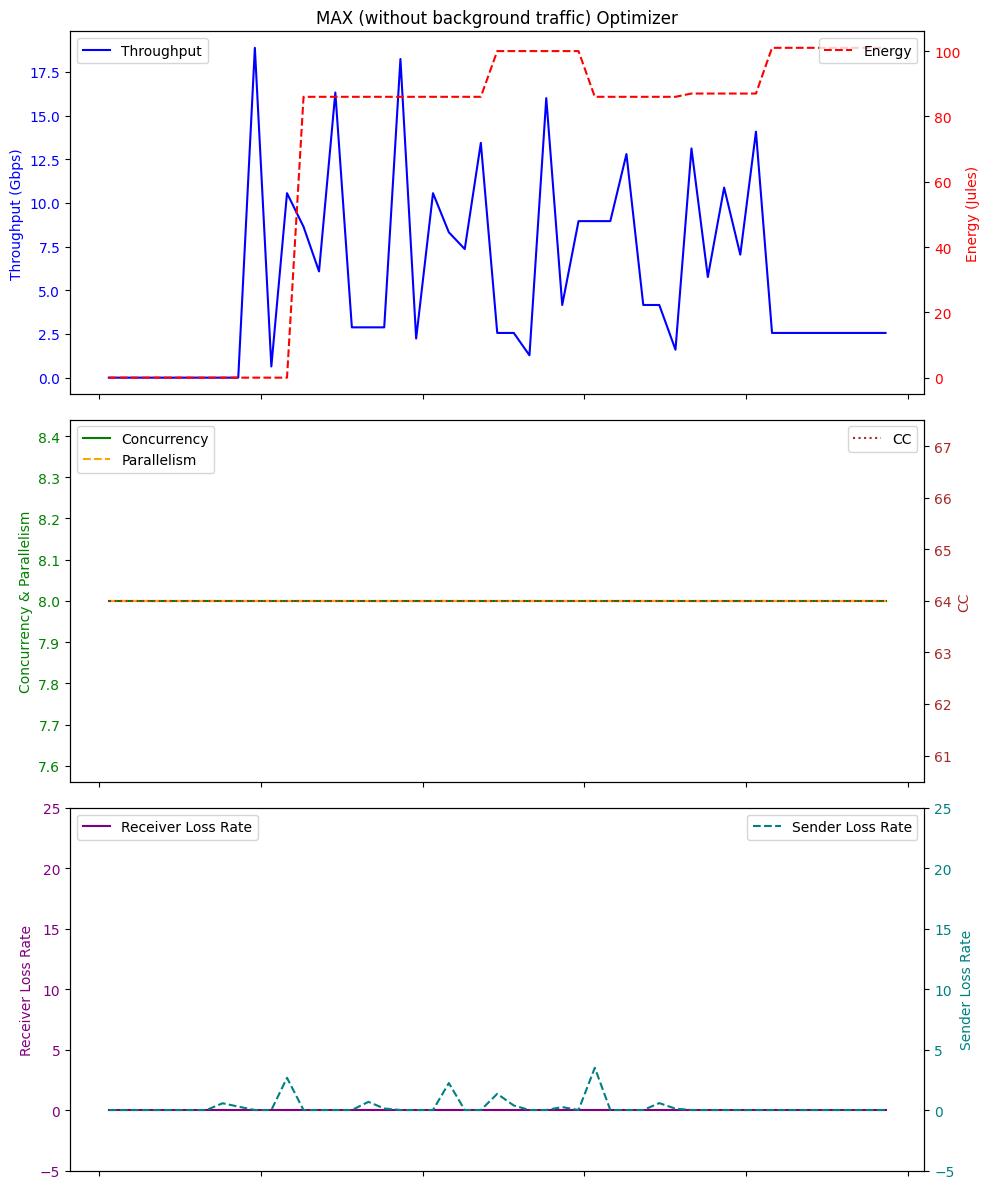

Average Throughput: 5.662040816326531
Total Energy: 3391.0
Total loss rate: 12.67859020835126


In [12]:
# Example usage
directory = './logFileDir/'
dfs = process_log_files(directory,"MAX_logFile_")

# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('MAX (without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.set_ylabel('Concurrency & Parallelism', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['CC'], label='CC', color='brown', linestyle=':')
    ax3_twin.set_ylabel('CC', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)

    ax3.set_ylim(-5,25)

    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    plt.savefig('withBT.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

    
average_throughput = df['Throughput'].mean()
print("Average Throughput:", average_throughput)

total_energy = df['Energy'].sum()
print("Total Energy:", total_energy)

total_plr = df['sender_lr'].sum()
print("Total loss rate:", total_plr)

                          Time  Throughput  receiver_lr  CC  Score   RTT  \
0   2023-12-26 23:51:09.885456        0.00          0.0   1    0.0   0.0   
1   2023-12-26 23:51:10.880164        0.00          0.0   4    0.0   0.0   
2   2023-12-26 23:51:11.880620        0.00          0.0   4    0.0  32.9   
3   2023-12-26 23:51:12.882768        0.00          0.0   4    0.0  32.7   
4   2023-12-26 23:51:13.884426        0.00          0.0   4    0.0  32.7   
..                         ...         ...          ...  ..    ...   ...   
309 2023-12-26 23:56:19.208734        0.32          0.0   1    0.0  32.7   
310 2023-12-26 23:56:20.208456        0.32          0.0   1    0.0  32.7   
311 2023-12-26 23:56:21.211046        0.32          0.0   1    0.0  32.6   
312 2023-12-26 23:56:22.211920        0.32          0.0   1    0.0  32.7   
313 2023-12-26 23:56:23.213120        0.32          0.0   1    0.0  32.7   

     Energy  sender_lr  concurrency  parallelism  
0       0.0        0.0            1 

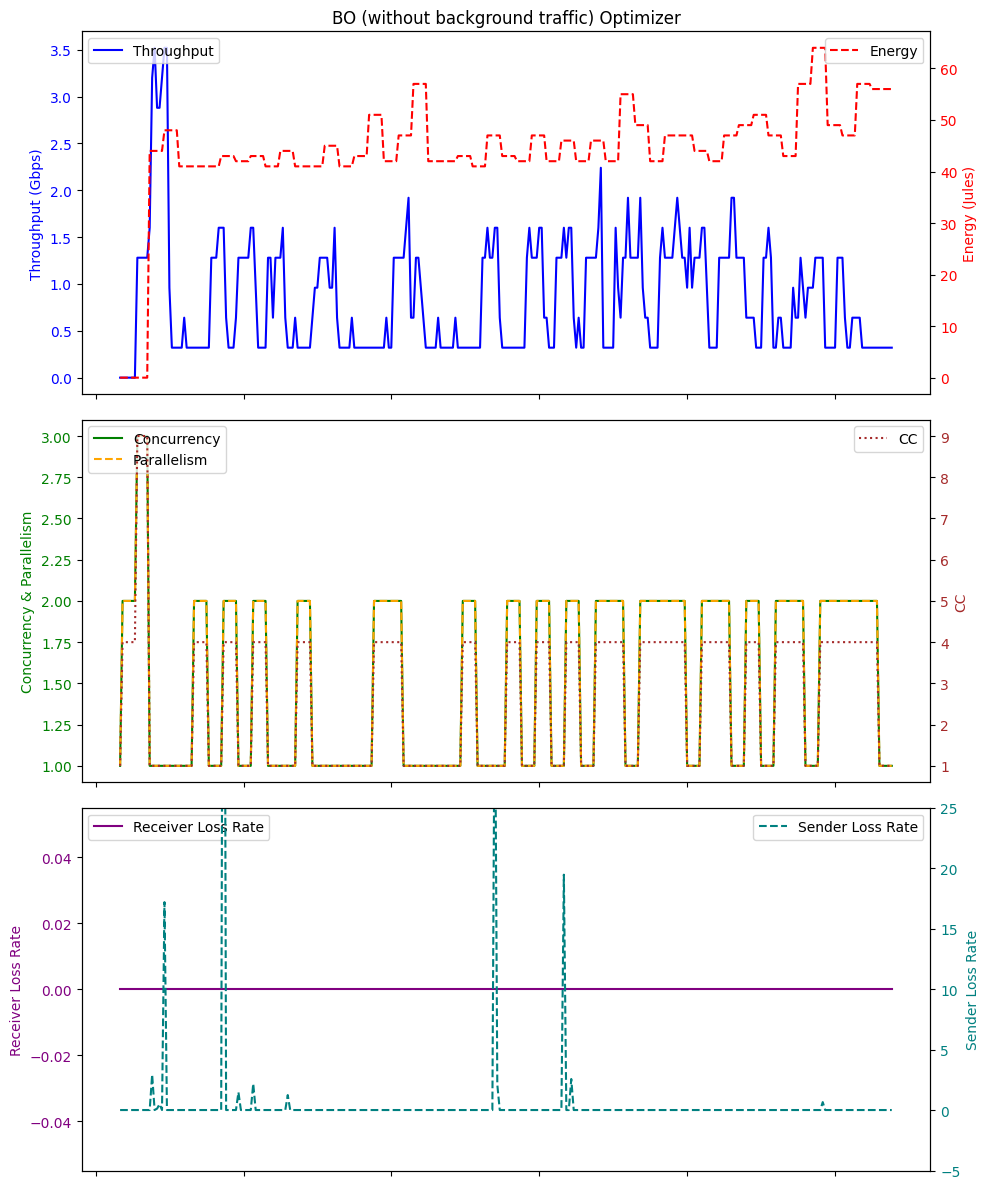

Average Throughput: 0.8478980891719745
Total Energy: 13891.0
Total loss rate: 164.36854868487043


In [13]:
# Example usage
directory = './logFileDir/'
dfs = process_log_files(directory,"BO_logFile_")

# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('BO (without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.set_ylabel('Concurrency & Parallelism', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['CC'], label='CC', color='brown', linestyle=':')
    ax3_twin.set_ylabel('CC', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)


    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    plt.savefig('withoutBT.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    
average_throughput = df['Throughput'].mean()
print("Average Throughput:", average_throughput)

total_energy = df['Energy'].sum()
print("Total Energy:", total_energy)

total_plr = df['sender_lr'].sum()
print("Total loss rate:", total_plr)


                          Time  Throughput  receiver_lr  CC  Score   RTT  \
0   2023-12-26 23:59:10.234328        0.00          0.0   1    0.0   0.0   
1   2023-12-26 23:59:11.229148        0.00          0.0   1    0.0   0.0   
2   2023-12-26 23:59:12.228994        0.00          0.0   1    0.0  32.7   
3   2023-12-26 23:59:13.231044        0.00          0.0   1    0.0  32.6   
4   2023-12-26 23:59:14.231300        0.00          0.0   1    0.0  32.6   
..                         ...         ...          ...  ..    ...   ...   
157 2023-12-27 00:01:47.379627        0.96          0.0  64    0.0  32.6   
158 2023-12-27 00:01:48.389860        0.96          0.0  64    0.0  32.6   
159 2023-12-27 00:01:49.390878        0.96          0.0  64    0.0  32.7   
160 2023-12-27 00:01:50.390606        0.96          0.0  64    0.0  32.8   
161 2023-12-27 00:01:51.393272        0.96          0.0  64    0.0  32.7   

     Energy  sender_lr  concurrency  parallelism  
0       0.0        0.0            1 

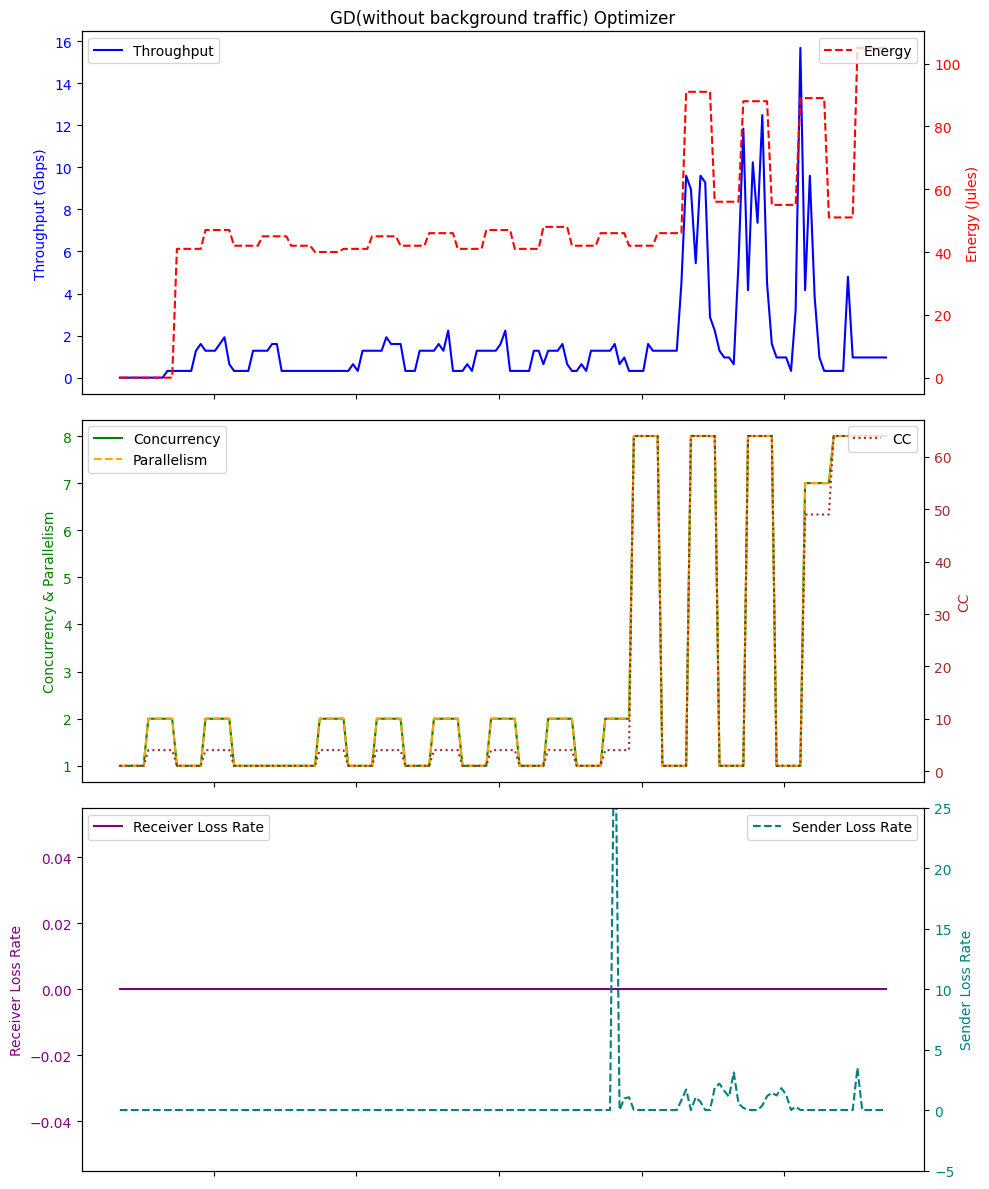

Average Throughput: 1.6414814814814815
Total Energy: 7977.0
Total loss rate: 64.06167165871364


In [14]:
# Example usage
directory = './logFileDir/'
dfs = process_log_files(directory,"GD_logFile_")

# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('GD(without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.set_ylabel('Concurrency & Parallelism', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['CC'], label='CC', color='brown', linestyle=':')
    ax3_twin.set_ylabel('CC', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)


    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
#     plt.savefig('GD.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

average_throughput = df['Throughput'].mean()
print("Average Throughput:", average_throughput)
total_energy = df['Energy'].sum()
print("Total Energy:", total_energy)

total_plr = df['sender_lr'].sum()
print("Total loss rate:", total_plr)

                         Time  Throughput  receiver_lr  CC  Score   RTT  \
0  2023-12-27 00:05:28.377889         0.0          0.0   1    0.0   0.0   
1  2023-12-27 00:05:29.373643         0.0          0.0  16    0.0   0.0   
2  2023-12-27 00:05:30.374990         0.0          0.0  16    0.0  32.6   
3  2023-12-27 00:05:31.375324         0.0          0.0  16    0.0  32.6   
4  2023-12-27 00:05:32.377754         0.0          0.0  16    0.0  32.6   
..                        ...         ...          ...  ..    ...   ...   
75 2023-12-27 00:06:43.447677         1.6          0.0  49    1.0  32.6   
76 2023-12-27 00:06:44.448014         1.6          0.0  49    1.0  32.6   
77 2023-12-27 00:06:45.449878         1.6          0.0  49    1.0  32.6   
78 2023-12-27 00:06:46.450460         1.6          0.0  49    1.0  32.6   
79 2023-12-27 00:06:48.045714         1.6          0.0   1    0.0   0.0   

    Energy  sender_lr  concurrency  parallelism  
0      0.0        0.0            1            1  

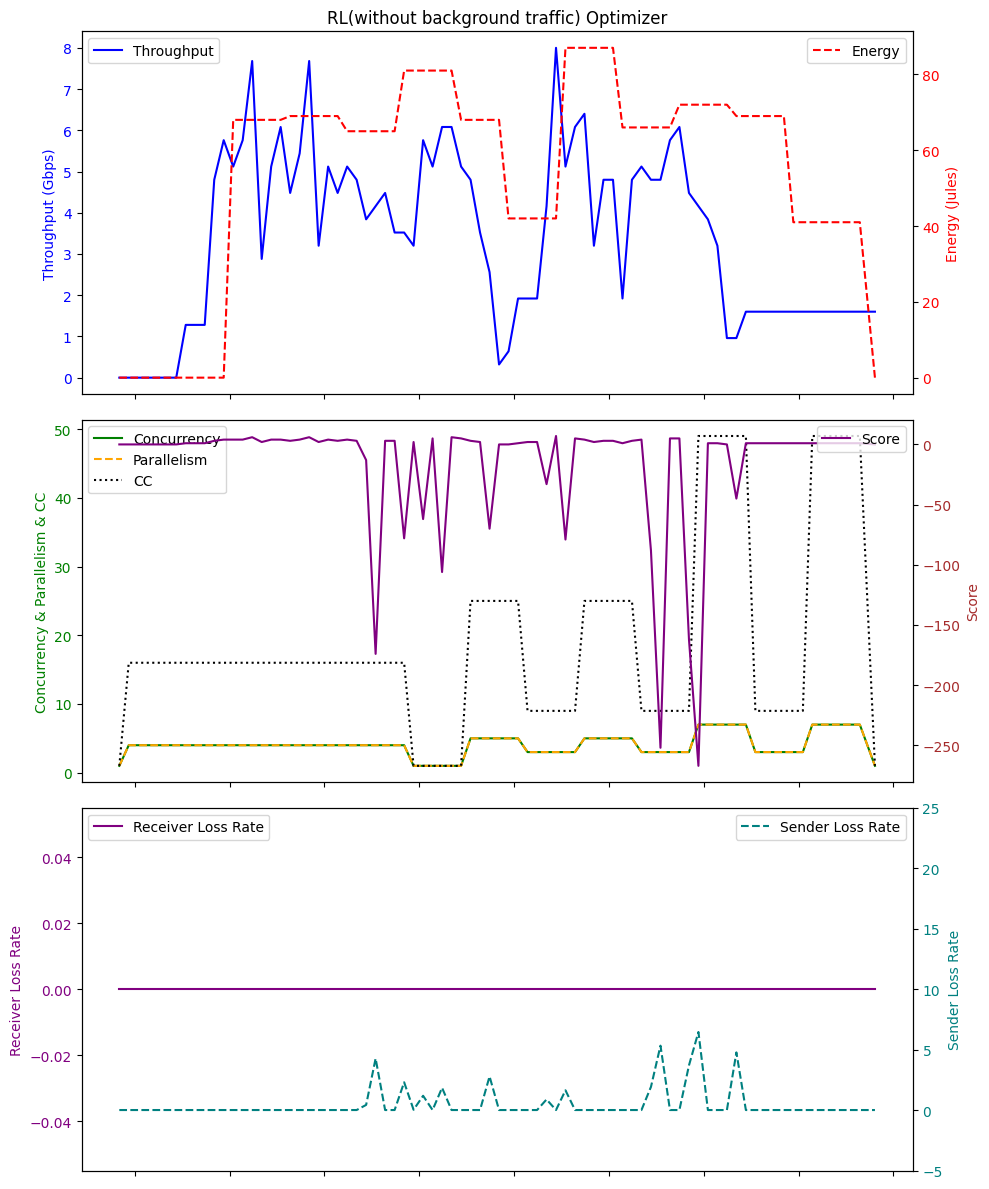

Average Throughput: 3.396000000000001
Total Energy: 4382.0
Total loss rate: 37.45043471764272


In [15]:
# Example usage
directory = './logFileDir/'
dfs = process_log_files(directory,"RL_logFile_")

# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('RL(without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.plot(df['Time'], df['CC'], label='CC', color='black', linestyle=':')
    ax2.set_ylabel('Concurrency & Parallelism & CC', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['Score'], label='Score', color='purple', linestyle='-')
    ax3_twin.set_ylabel('Score', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)


    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
#     plt.savefig('BO.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

average_throughput = df['Throughput'].mean()
print("Average Throughput:", average_throughput)

total_energy = df['Energy'].sum()
print("Total Energy:", total_energy)

total_plr = df['sender_lr'].sum()
print("Total loss rate:", total_plr)

In [ ]:
# Example usage
directory = './logFileDir/'
dfs = process_log_files(directory,"gd_logFile_")
# print(dfs)
# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('GD(without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.plot(df['Time'], df['CC'], label='CC', color='black', linestyle=':')
    ax2.set_ylabel('Concurrency & Parallelism & CC', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['Score'], label='Score', color='purple', linestyle='-')
    ax3_twin.set_ylabel('Score', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
#     ax3.plot(df['Time'], df['Score'], label='Score', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)
    ax3.set_ylim(-5,25)

    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    plt.show()

In [ ]:
# Example usage
directory = './logFileDir/'
dfs = process_log_files(directory,"bo_logFile_")

# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('BO(without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.plot(df['Time'], df['CC'], label='CC', color='black', linestyle=':')
    ax2.set_ylabel('Concurrency & Parallelism & CC', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['Score'], label='Score', color='purple', linestyle='-')
    ax3_twin.set_ylabel('Score', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
#     ax3.plot(df['Time'], df['Score'], label='Score', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)
    ax3.set_ylim(-5,25)

    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
#     plt.savefig('BO.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Example usage
directory = './logFileDir/'
dfs = process_log_files(directory,"ppo_logFile_12_26_2023_22_42_37")

# Print or process the dataframes as needed
for df in dfs:
    print(df)
    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)


    # Top plot with Throughput and Energy
    ax1.plot(df['Time'], df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('PPO (without background traffic) Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Time'], df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Time'], df['concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Time'], df['parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.plot(df['Time'], df['CC'], label='CC', color='black', linestyle=':')
    ax2.set_ylabel('Concurrency & Parallelism & CC', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    ax3_twin = ax2.twinx()
    ax3_twin.plot(df['Time'], df['Score'], label='Score', color='purple', linestyle='-')
    ax3_twin.set_ylabel('Score', color='brown')
    ax3_twin.tick_params(axis='y', labelcolor='brown')
    
    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot(df['Time'], df['receiver_lr'], label='Receiver Loss Rate', color='purple', linestyle='-')
#     ax3.plot(df['Time'], df['Score'], label='Score', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot(df['Time'], df['sender_lr'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
    ax4_twin.set_ylim(-5,25)
    ax3.set_ylim(-5,25)

    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
#     plt.savefig('BO.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()